<a href="https://colab.research.google.com/github/Codequirk/CodSoft/blob/main/task_2_Movie_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMDB dataset Movie Rating Prediction Model


In [40]:
#Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import MultiOutputRegressor

from sklearn.preprocessing import MultiLabelBinarizer
import math
import warnings
warnings.filterwarnings('ignore')

In [41]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDb Movies India.csv', encoding='ISO-8859-1')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [42]:
# quick info
print(df.shape)
df.info()
df.isnull().sum()


(15509, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


,0
Name,0
Year,528
Duration,8269
Genre,1877
Rating,7590
Votes,7589
Director,525
Actor 1,1617
Actor 2,2384
Actor 3,3144


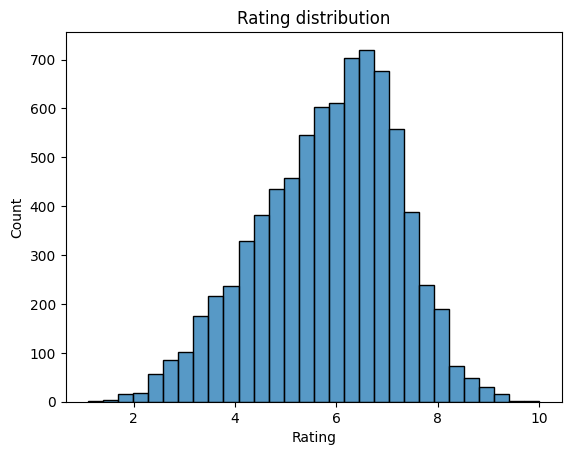

In [43]:
#Checking the distribution of ratings among various movies to preprocess further data
df['Rating'].describe()
sns.histplot(df['Rating'].dropna(), bins=30)
plt.title('Rating distribution')
plt.show()


In [44]:
cols_needed = ['Name','Year','Duration','Genre','Rating','Votes','Director','Actor 1','Actor 2','Actor 3']
cols_present = [c for c in cols_needed if c in df.columns]
df = df[cols_present].copy()

In [45]:
#data cleaning:taking care of null values for less data traffic
df = df[~df['Rating'].isnull()].copy()

if 'Duration' in df.columns:
    df['Duration'] = df['Duration'].astype(str)
    df['Duration'] = df['Duration'].str.replace('min','',regex=False).str.strip()
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

if 'Votes' in df.columns:
    df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

for c in ['Duration','Votes']:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())


for c in ['Genre','Director','Actor 1','Actor 2','Actor 3']:
    if c in df.columns:
        df[c] = df[c].fillna('Unknown')


In [46]:
print(df['Year'].unique()[:20])


['(2019)' '(1997)' '(2005)' '(2012)' '(2014)' '(2004)' '(2016)' '(1991)'
 '(2018)' '(2010)' '(1958)' '(2021)' '(2017)' '(2009)' '(1993)' '(2002)'
 '(1946)' '(2008)' '(1994)' '(2007)']


In [47]:
#making a list of different genre in a movie and counting number of genre
def split_genres(g):
    if pd.isna(g): return []
    return [x.strip() for x in str(g).split(',') if x.strip()!='']

df['Genre_list'] = df['Genre'].apply(split_genres)
df['NumGenres'] = df['Genre_list'].apply(len)

#adding decade column to convert year into decade values
df['Year'] = df['Year'].astype(str).str.extract(r'(\d{4})').astype(float)
df['Decade'] = (df['Year'] // 10 * 10).astype('Int64')

df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce').fillna(df['Duration'].median())



df['LogVotes'] = np.log1p(df['Votes'])

#to check how many directors or actors present for a movie
df['HasDirector'] = df['Director'].apply(lambda x: 0 if x in [None,'Unknown',''] else 1)
df['HasActors'] = df[['Actor 1','Actor 2','Actor 3']].apply(lambda row: sum([0 if (str(x).strip() in ['','Unknown','nan']) else 1 for x in row]), axis=1)


In [48]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre_list,NumGenres,Decade,LogVotes,HasDirector,HasActors
1,#Gadhvi (He thought he was Gandhi),2019.0,109.0,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,[Drama],1,2010,2.197225,1,3
3,#Yaaram,2019.0,110.0,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,"[Comedy, Romance]",2,2010,3.583519,1,3
5,...Aur Pyaar Ho Gaya,1997.0,147.0,"Comedy, Drama, Musical",4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,"[Comedy, Drama, Musical]",3,1990,6.719013,1,3
6,...Yahaan,2005.0,142.0,"Drama, Romance, War",7.4,35.0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,"[Drama, Romance, War]",3,2000,3.583519,1,3
8,?: A Question Mark,2012.0,82.0,"Horror, Mystery, Thriller",5.6,326.0,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,"[Horror, Mystery, Thriller]",3,2010,5.789960,1,3


In [49]:
#diving the data into train test data(80 %-train,20%test)
TARGET = 'Rating'
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


(6335, 15) (1584, 15)


In [50]:
X_train.head()
X_test.head()


,Name,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3,Genre_list,NumGenres,Decade,LogVotes,HasDirector,HasActors
9456,Mohabbat Pehli Nazar Mein,1991.0,134.0,Romance,6.0,Gautam Siddhartha,Akshay Anand,Sangeeta Ghosh,Amjad Khan,[Romance],1,1990,1.945910,1,3
14816,Veerappan,2016.0,125.0,"Action, Biography, Crime",711.0,Ram Gopal Varma,Sachiin Joshi,Sandeep Bharadwaj,Usha Jadhav,"[Action, Biography, Crime]",3,2010,6.568078,1,3
3213,Commando 3,2019.0,133.0,"Action, Adventure, Thriller",35.0,Aditya Datt,Vidyut Jammwal,Adah Sharma,Gulshan Devaiah,"[Action, Adventure, Thriller]",3,2010,3.583519,1,3
3778,Dhoop,2003.0,126.0,Drama,242.0,Ashwini Chaudhary,Om Puri,Revathi,Gul Panag,[Drama],1,2000,5.493061,1,3
5775,Horror Night,2017.0,115.0,Horror,11.0,Suraj Bharti,Sahilraj Dewangen,Johnny Janarden,Shubham Kathe,[Horror],1,2010,2.484907,1,3


In [51]:
# Combine X_train and y_train to compute group stats
train_combined = X_train.copy()
train_combined[TARGET] = y_train

# calculating the mean rating of director and movie count of each director
if 'Director' in X_train.columns:
    director_stats = train_combined.groupby('Director')[TARGET].agg(['mean','count']).rename(columns={'mean':'director_mean_rating','count':'director_movie_count'})
    global_mean = y_train.mean()

    X_train = X_train.copy()
    X_test = X_test.copy()

    X_train = X_train.merge(director_stats, how='left', left_on='Director', right_index=True)
    X_test = X_test.merge(director_stats, how='left', left_on='Director', right_index=True)

    X_train['director_mean_rating'] = X_train['director_mean_rating'].fillna(global_mean)
    X_test['director_mean_rating']  = X_test['director_mean_rating'].fillna(global_mean)

    X_train['director_movie_count'] = X_train['director_movie_count'].fillna(0)
    X_test['director_movie_count']  = X_test['director_movie_count'].fillna(0)

# Calculating mean rating and movie count for each actor
actor_cols = [c for c in ['Actor 1','Actor 2','Actor 3'] if c in X_train.columns]
for a in actor_cols:
    stats = train_combined.groupby(a)[TARGET].agg(['mean','count']).rename(columns={'mean':f'{a}_mean_rating', 'count':f'{a}_movie_count'})
    X_train = X_train.merge(stats, how='left', left_on=a, right_index=True)
    X_test = X_test.merge(stats, how='left', left_on=a, right_index=True)


    X_train[f'{a}_mean_rating'] = X_train[f'{a}_mean_rating'].fillna(global_mean)
    X_test[f'{a}_mean_rating']  = X_test[f'{a}_mean_rating'].fillna(global_mean)
    X_train[f'{a}_movie_count'] = X_train[f'{a}_movie_count'].fillna(0)
    X_test[f'{a}_movie_count']  = X_test[f'{a}_movie_count'].fillna(0)

# Combining mean rating and movie count of actors to calculate star power
if actor_cols:
    actor_mean_cols = [f'{a}_mean_rating' for a in actor_cols]
    X_train['star_power'] = X_train[actor_mean_cols].mean(axis=1)
    X_test['star_power']  = X_test[actor_mean_cols].mean(axis=1)
else:
    X_train['star_power'] = 0
    X_test['star_power'] = 0


In [52]:
X_train.head()
X_test.head()


,Name,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3,Genre_list,...,HasActors,director_mean_rating,director_movie_count,Actor 1_mean_rating,Actor 1_movie_count,Actor 2_mean_rating,Actor 2_movie_count,Actor 3_mean_rating,Actor 3_movie_count,star_power
9456,Mohabbat Pehli Nazar Mein,1991.0,134.0,Romance,6.0,Gautam Siddhartha,Akshay Anand,Sangeeta Ghosh,Amjad Khan,[Romance],...,3,5.831018,0.0,3.600000,3.0,5.831018,0.0,5.719048,21.0,5.050022
14816,Veerappan,2016.0,125.0,"Action, Biography, Crime",711.0,Ram Gopal Varma,Sachiin Joshi,Sandeep Bharadwaj,Usha Jadhav,"[Action, Biography, Crime]",...,3,5.341379,29.0,4.900000,1.0,5.831018,0.0,5.831018,0.0,5.520679
3213,Commando 3,2019.0,133.0,"Action, Adventure, Thriller",35.0,Aditya Datt,Vidyut Jammwal,Adah Sharma,Gulshan Devaiah,"[Action, Adventure, Thriller]",...,3,4.500000,5.0,6.083333,6.0,5.025000,4.0,5.300000,2.0,5.469444
3778,Dhoop,2003.0,126.0,Drama,242.0,Ashwini Chaudhary,Om Puri,Revathi,Gul Panag,[Drama],...,3,4.425000,4.0,6.126667,15.0,6.600000,4.0,5.866667,3.0,6.197778
5775,Horror Night,2017.0,115.0,Horror,11.0,Suraj Bharti,Sahilraj Dewangen,Johnny Janarden,Shubham Kathe,[Horror],...,3,5.831018,0.0,5.831018,0.0,5.831018,0.0,5.831018,0.0,5.831018


In [53]:
# Find top N genres in training
all_genres = X_train['Genre_list'].explode().value_counts()
top_genres = list(all_genres.head(12).index)  # keep top 12 genres

mlb = MultiLabelBinarizer(classes=top_genres)
train_genres = mlb.fit_transform(X_train['Genre_list'])
test_genres  = mlb.transform(X_test['Genre_list'])

# convert to DataFrame and concat
train_genre_df = pd.DataFrame(train_genres, columns=[f'genre_{g}' for g in mlb.classes_], index=X_train.index)
test_genre_df  = pd.DataFrame(test_genres,  columns=[f'genre_{g}' for g in mlb.classes_], index=X_test.index)

X_train = pd.concat([X_train, train_genre_df], axis=1)
X_test  = pd.concat([X_test, test_genre_df], axis=1)


In [54]:
X_train.head()
X_test.head()

,Name,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3,Genre_list,...,genre_Romance,genre_Comedy,genre_Crime,genre_Thriller,genre_Family,genre_Musical,genre_Adventure,genre_Mystery,genre_Horror,genre_Fantasy
9456,Mohabbat Pehli Nazar Mein,1991.0,134.0,Romance,6.0,Gautam Siddhartha,Akshay Anand,Sangeeta Ghosh,Amjad Khan,[Romance],...,1,0,0,0,0,0,0,0,0,0
14816,Veerappan,2016.0,125.0,"Action, Biography, Crime",711.0,Ram Gopal Varma,Sachiin Joshi,Sandeep Bharadwaj,Usha Jadhav,"[Action, Biography, Crime]",...,0,0,1,0,0,0,0,0,0,0
3213,Commando 3,2019.0,133.0,"Action, Adventure, Thriller",35.0,Aditya Datt,Vidyut Jammwal,Adah Sharma,Gulshan Devaiah,"[Action, Adventure, Thriller]",...,0,0,0,1,0,0,1,0,0,0
3778,Dhoop,2003.0,126.0,Drama,242.0,Ashwini Chaudhary,Om Puri,Revathi,Gul Panag,[Drama],...,0,0,0,0,0,0,0,0,0,0
5775,Horror Night,2017.0,115.0,Horror,11.0,Suraj Bharti,Sahilraj Dewangen,Johnny Janarden,Shubham Kathe,[Horror],...,0,0,0,0,0,0,0,0,1,0


In [55]:
# columns to drop (text columns we no longer need)
drop_cols = ['Name','Genre','Genre_list','Director','Actor 1','Actor 2','Actor 3']
for c in drop_cols:
    if c in X_train.columns:
        X_train.drop(columns=[c], inplace=True)
        X_test.drop(columns=[c], inplace=True)

# Fill any remaining NaNs (safety)
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)

# Final feature list
feature_cols = X_train.columns.tolist()
print("Number of features:", len(feature_cols))
feature_cols[:30]


Number of features: 29


['Year',
 'Duration',
 'Votes',
 'NumGenres',
 'Decade',
 'LogVotes',
 'HasDirector',
 'HasActors',
 'director_mean_rating',
 'director_movie_count',
 'Actor 1_mean_rating',
 'Actor 1_movie_count',
 'Actor 2_mean_rating',
 'Actor 2_movie_count',
 'Actor 3_mean_rating',
 'Actor 3_movie_count',
 'star_power',
 'genre_Drama',
 'genre_Action',
 'genre_Romance',
 'genre_Comedy',
 'genre_Crime',
 'genre_Thriller',
 'genre_Family',
 'genre_Musical',
 'genre_Adventure',
 'genre_Mystery',
 'genre_Horror',
 'genre_Fantasy']

#Linear Regression


In [57]:

lr_pipeline = make_pipeline(StandardScaler(), LinearRegression())
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

def eval_reg(y_true, y_pred, label='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

eval_reg(y_test, y_pred_lr, 'LinearRegression (baseline)')


LinearRegression (baseline) -> MAE: 0.919, RMSE: 1.183, R2: 0.247


Random Forest Regressior

In [58]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
eval_reg(y_test, y_pred_rf, 'RandomForest')


RandomForest -> MAE: 0.934, RMSE: 1.222, R2: 0.196


Gradient Boosting Regression

In [59]:
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
eval_reg(y_test, y_pred_gbr, 'GradientBoosting')


GradientBoosting -> MAE: 0.913, RMSE: 1.193, R2: 0.234


Comparison

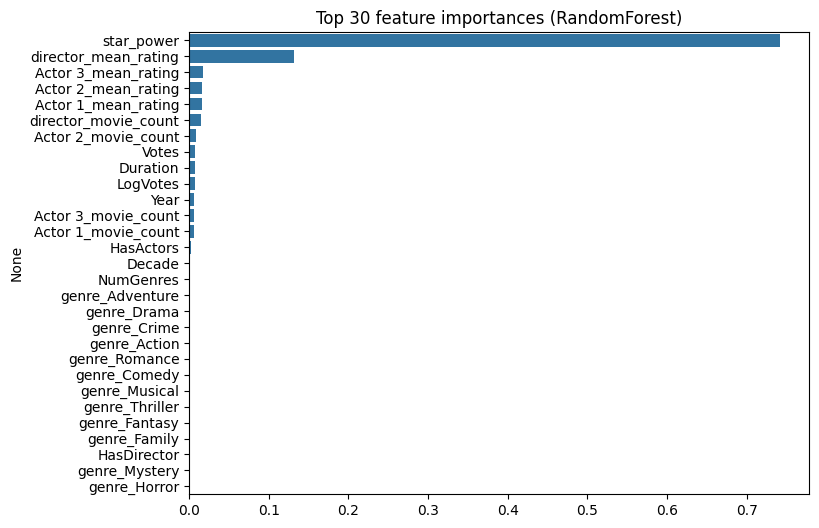

In [60]:
# feature importances
fi = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False).head(30)
plt.figure(figsize=(8,6))
sns.barplot(y=fi.index, x=fi.values)
plt.title('Top 30 feature importances (RandomForest)')
plt.show()


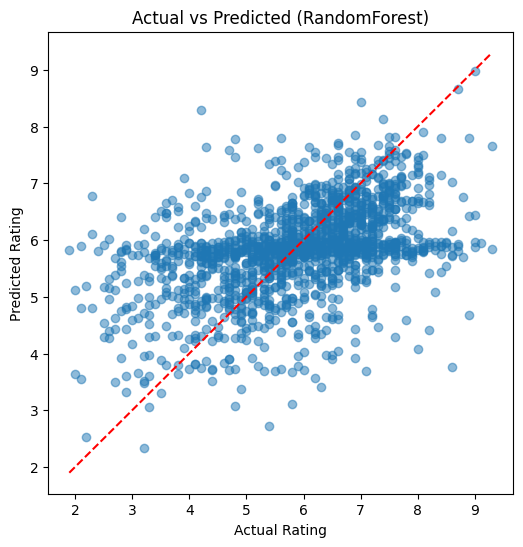

In [61]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rating'); plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted (RandomForest)')
plt.show()
